In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from scipy import stats
import pingouin #T-test
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from optbinning import BinningProcess

import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os


# Colocación

In [198]:
# Ingreso de datos excel
col  = pd.read_excel('000 COLOCACION 2017 2021.xlsx')

# Cambiar nombre del codeudor por variable binaria (1-> Sin codeudor; 2-> Con codeudor )
def assign_label(row): 
    if row['Codeudor'] == 'SIN CODEUDORES': 
        label = 1  
    else: 
        label = 0 
    return label 
 
col['Codeudor_ref'] = col.apply(lambda row:assign_label(row), axis = 1)


# Eliminar columnas no necesarias para el EDA
col.drop(['Cod_Sucursal','Tel. Fijo','Celular','correo','Direccion','Tipo_Obliga','Tipo_Documento','Cedula','Unnamed: 54','Nombre',
         'Cod_Destinacion', 'Cod_Modalidad','Cod_linea','Fecha_Nacimiento','Identi_Ejecutivo', 'Nombre_Ejecutivo',
        'Solicitud','Sucursal_Contabiliza','Nombre_Usuario','Codeudor'], axis=1, inplace=True)

# Poner todas las colunas en minusula y reemplazar espacios por barras 
col.columns = col.columns.str.upper()
col.columns = col.columns.str.replace(' ','_')

# Reemplazar registros unicos por "SIN VIVIENDA"
col['TIPO_VIVIENDA']  = col['TIPO_VIVIENDA'].replace({'SIN VIVIENDA': 'SIn vivienda',
                                                    '24048011  TORRES MOLANO DORIS LUCIA CALIFICACION: I':'Otra',
                                                    'Inmueble con Hipoteca':'Otra'},regex=True)

# Generos esconocido marcado como datos nulos
col['GENERO']  = col['GENERO'].replace({'DESCONOCIDA': np.nan},regex=True)

# Tipo de creditos vacio e iguales a 1  reemplazado por sin perfil 
col['TIPO_CREDITO']  = col['TIPO_CREDITO'].replace({np.nan:'SIN PERFIL',
'1':'SIN PERFIL'},regex=True)

# Ajustar valor atipico en fecha para calcular edad y en periodicidad de pago
col['EDAD']  = col['EDAD'].replace({'1950-09-10 00:00:0': np.nan},regex=True)
col['PERIODICIDAD_PAGO']  = col['PERIODICIDAD_PAGO'].replace({'2021-09-10 00:00:00': np.nan},regex=True)

# Definición de algunos tipos de variables
col['CODEUDOR_REF'] = col['CODEUDOR_REF'].astype('category')
#col['EDAD'] = col['EDAD'].astype('float')

# Cartera

## Merge de archivos / Drop de variables con 80% de datos nulos

In [4]:
# Union de archivos de cartera
"""
path='C://Users//MIPC//Desktop//DS4A//FUNDACIÓN AMANECER//GERMAN GONZALEZ ACEVEDO - FUNDACION AMANECER_RETOS_MINTIC_2022//2017-2021'
pathuni='.'
os.chdir(path)
monthdict = {
  "ENERO": "01",
  "FEBRERO": "02",
  "MARZO": "03",
    "ABRIL": "04",
    "MAYO": "05",
    "JUNIO": "06",
    "JULIO": "07",
    "AGOSTO": "08",
    "SEPTIEMBRE": "09",
    "OCTUBRE": "10",
    "NOVIEMBRE": "11",
    "DICIEMBRE": "12"
}

data=pd.read_csv(pathuni+'/'+'FUNDACIÓN AMANECER_RETO_CIERRE CARTERA ABRIL 2017.csv',index_col=0, sep=';', encoding='latin-1')
data.columns= data.columns.str.upper()
data.columns= data.columns.str.strip()
for file in os.listdir():
    if(file=='FUNDACIÓN AMANECER_RETO_CIERRE CARTERA ABRIL 2017.csv'): 
        name= file.split()
        data['Fecha']= monthdict[str(name[3])]+ "/" + str(name[4][0:4])
        pass
    name= file.split()
    data_aux=pd.read_csv(pathuni+'/'+file,index_col=0, sep=';', encoding='latin-1')
    data_aux.columns= data_aux.columns.str.upper()
    data_aux.columns= data_aux.columns.str.strip()
    data_aux['Fecha']= monthdict[str(name[3])]+ "/" + str(name[4][0:4])
    data=pd.concat([data,data_aux], axis=0)

"""

# Drop columnas que no se van a usarpor tener mas del 80% de datos nulos

"""
data = data.drop(['FEC NACIMIENTO', 'EDAD', 'MUJER CABEZA',
       'FACTORRH', 'PROFESION', 'GENERO', 'ESTRATO', 'NIVEL ESTUDIO','RANGO PAGO', 'CEDULA', 'NOMBRE', 'EJECUTIVO ACTUAL',
       'EST CIVIL', 'FECHA UTL ACTUALIZACION', 'TEL.FIJO',
       'CELULAR', 'DIRECCION', 'CORREO','REGION.1', 'MUNICIPIO',
       'BUS REGION', 'REGION - REAL'], 1)
"""

"\n\ndata = data.drop(['FEC NACIMIENTO', 'EDAD', 'MUJER CABEZA',\n       'FACTORRH', 'PROFESION', 'GENERO', 'ESTRATO', 'NIVEL ESTUDIO','RANGO PAGO', 'CEDULA', 'NOMBRE', 'EJECUTIVO ACTUAL',\n       'EST CIVIL', 'FECHA UTL ACTUALIZACION', 'TEL.FIJO',\n       'CELULAR', 'DIRECCION', 'CORREO','REGION.1', 'MUNICIPIO',\n       'BUS REGION', 'REGION - REAL'], 1)\n\n"

## Limpieza de cartera

### Limpieza individual

In [ ]:
"""
# Eliminar variables que no aportan al objetivo del proyecto
data = data.drop(columns = ['OTROS','GARNTIA REAL','Unnamed: 38'])

# Eliminar lineas repetidas por merge
df.drop_duplicates(inplace = True)

# Eliminar comas en valor cuota para que lo reconozca como numero
df['VALOR CUOTA'] = df['VALOR CUOTA'].replace(',','',regex=True).astype("float")

# Eliminar comas y "-" como ceros (tener cero si es un valor a considerar no debe ser NAN) 
df['SALDO OBLIGACION'] = df['SALDO OBLIGACION'].replace(',','',regex=True).astype("int")
df['VENCIDA'] = df['VENCIDA'].replace({',':'',
                                      '-':0},regex=True).astype("int")

# Eliminar comas / "-" como ceros / Poner valores en parentesis como negativos
to_integrer = ['MORA','CAPITAL VEN','INTERES VEN','COMISION']
for i in to_integrer:
    df[i] = df[i].replace({' -   ': '0',
                                    ',': ''}, 
                                    regex = True)
    df[i] = df[i].str.strip()
    df[i] = df[i].replace({'\((\d+)\)': '-\\1'}, 
                                    regex = True).astype("int")
    

# Reemplazar numerales por NAN
df['PORCENTAJE PAGO'] = df['PORCENTAJE PAGO'].replace('######', np.nan)

# Corregir tasas que no quedaron con separadores decimales
def assign_rate_year(row): 
    if row['TASA N.A.M.V'] > 100: 
        label = row['TASA N.A.M.V']/100 
    else: 
        label = row['TASA N.A.M.V']
    return label 
 
df['TASA_NOM_ANUAL'] = df.apply(lambda row:assign_rate_year(row), axis = 1)

def assign_rate_per(row): 
    if row['TASA PERIODICA'] > 100: 
        label = row['TASA PERIODICA']/100 
    else: 
        label = row['TASA PERIODICA']
    return label 
 
df['TASA_PERIODICA'] = df.apply(lambda row:assign_rate_per(row), axis = 1)


# Llenar cedula fantante con respecto a la obligación
id_obli = df.groupby(['OBLIGACION','HOMOLOGACION DOCUMENTO DE IDENTIDAD'])['PAGARE'].count().reset_index()
id_obli.drop('PAGARE', axis = 1, inplace = True)
id_obli.drop_duplicates(inplace = True)
id_obli.rename(columns = {'HOMOLOGACION DOCUMENTO DE IDENTIDAD':'ID'},inplace = True)

df_complete = df.merge(id_obli, on = 'OBLIGACION', how = 'right') 

# Eliminar columnas que interesan ya que se crearon nuevas con la limpieza
df_complete = df_complete.drop(['HOMOLOGACION DOCUMENTO DE IDENTIDAD','TASA PERIODICA',
                               'SUCURSAL','TASA N.A.M.V','MODALIDAD'], axis = 1)

# Agregar variables CP PP
df_complete['PP'] = 0 #Periodo o registro en el cual paga
df_complete['CP'] = 0 #Capital que consigue pagar
for indice, row in df_complete.iterrows():   
    if indice > 0:
        if df_complete.at[indice,'OBLIGACION']==df_complete.at[(indice)-1,'OBLIGACION']:
            if df_complete.at[indice,'SALDO OBLIGACION']<df_complete.at[(indice)-1,'SALDO OBLIGACION']:
                if df_complete.at[indice,'DIAS VENCIDO']>0:
                    df_complete.at[indice,'PP'] = 1
                    df_complete.at[indice,'CP'] = df_complete.at[(indice)-1,'SALDO OBLIGACION'] - df_complete.at[indice,'SALDO OBLIGACION']

# Falta agregar GENERO, EDAD, NIVEL DE ESTUDIOS,  MORA_STATUS de dataset clientes

"""

### Limpieza merge

In [35]:
# Obtener df_complete 
df_completo = pd.read_csv('Cartera_Final_2.csv', sep=",",encoding="utf-8",low_memory=False)
df_completo.drop(columns = ['Unnamed: 0.1','Unnamed: 0'], inplace = True)

#Unir con colocación
sucursal_ref = col[['OBLIGACION','SUCURSAL','ESTRATO','DESTINACION','TIPO_VIVIENDA','CODEUDOR_REF']]
data_completo = df_completo.merge(sucursal_ref, on = 'OBLIGACION', how = 'left')

# Poner nombre de variables en minuscula y sin espacios
data_completo.columns = data_completo.columns.str.upper()
data_completo.columns = data_completo.columns.str.replace(' ','_')

# Recategorizar nivel educación por obli
def assign_label(row): 
    if (row['NIVEL_DE_ESTUDIOS'] =='Primaria ') | (row['NIVEL_DE_ESTUDIOS'] =='Secundaria '): 
        label = "Basica"  
    elif(row['NIVEL_DE_ESTUDIOS'] =='Tecnológica ') | (row['NIVEL_DE_ESTUDIOS'] =='Tecnica '):
        label = "Media"   
    elif(row['NIVEL_DE_ESTUDIOS'] =='Especializacion ') | (row['NIVEL_DE_ESTUDIOS'] =='Doctorado ') | (row['NIVEL_DE_ESTUDIOS'] =='Universitaria ') | (row['NIVEL_DE_ESTUDIOS'] =='Maestria '):
        label = "Superior"  
    elif(row['NIVEL_DE_ESTUDIOS'] =='No escolarizado ') | (row['NIVEL_DE_ESTUDIOS'] =='Analfabetismo '):
        label = "Ninguno"
    else:
        label = "Desconocido"
    return label 

df_completo['NIVEL_DE_ESTUDIOS_NEW'] = df_obligacion.apply(lambda row:assign_label(row), axis = 1)

#Eliminar lineas creadas antes del 2017
data_completo = data_completo.drop(data_completo[data_completo['SUCURSAL'].isnull()].index)

In [37]:
# Crear varaibles nuevas: Deudor, si incurrio en mora o no. Acumulado: Cuantas cuotas consecutivas estuvo en mora
data_completo.sort_values(by=['OBLIGACION','FECHA'], ascending=True,inplace = True)
data_completo.reset_index(drop=True, inplace=True)

data_completo['DEUDOR'] = 0
data_completo.loc[data_completo['DIAS_VENCIDO'] > 0,'DEUDOR'] = 1

n = data_completo.shape[0]
x = 0
data_completo['ACUMULADO'] = 0 

for i in range(1,n-1):
    y = data_completo.loc[i-1,'DEUDOR']

    if (y == 1) :
        x = x + y
        if  (data_completo.loc[i-1,'OBLIGACION'] !=  data_completo.loc[i,'OBLIGACION']):
            data_completo.at[i-1,'ACUMULADO'] = x
            x = 0
    else:
        data_completo.at[i-1,'ACUMULADO'] = x
        x = 0

In [164]:
# Dataset agrupado para analisis
## Agrupacion de datos en mora por promedio de momentos donde hubo cambio
var_agrupacion = ['DIAS_VENCIDO','CAPITAL_VEN','INTERES_VEN','MORA','COMISION']
df_vencido = data_completo[data_completo['PP']==1]
obli_vencida = df_vencido.groupby('OBLIGACION')[var_agrupacion].mean().reset_index()

## Agrupacion para cantidad de cuotas en mora
acumulado = data_completo.groupby(['OBLIGACION']).agg(MESES_EN_MORA = ('DEUDOR','sum'),
                                                     ACUMULADO = ('ACUMULADO','max')).reset_index()
df_obligacion_single = acumulado.merge(obli_vencida, on ='OBLIGACION', how='left' )

##Dataset final
df_obligacion = data_completo.drop_duplicates(subset='OBLIGACION')
df_obligacion.drop(['DIAS_VENCIDO','CAPITAL_VEN','INTERES_VEN','MORA','COMISION','ACUMULADO'], axis=1, inplace=True)
loan_data = df_obligacion.merge(df_obligacion_single, on = 'OBLIGACION', how = 'left')

# Llenar null de df_vencido
for i in var_agrupacion:
    loan_data[i].fillna(0, inplace = True)

# Drop columnas con pocos datos
loan_data.drop(['PORCENTAJE_PAGO','CUOTAS_PENDIENTES','FEC_ULT.PAGO','FEC_PROXIMO_PAGO','VENCIMIENTO_FINAL','PP','CP','VENCIDA','ID'], axis=1, inplace=True)

#Redefinir deudor
loan_data.loc[loan_data['MESES_EN_MORA'] > 0,'DEUDOR'] = 1



C:\Users\LAURA\AppData\Local\Temp\ipykernel_19096\1604541282.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obligacion.drop(['DIAS_VENCIDO','CAPITAL_VEN','INTERES_VEN','MORA','COMISION','ACUMULADO'], axis=1, inplace=True)


In [165]:
# Definir tipos de datos
trans_obj = ['NRO_SOLICITUD','OBLIGACION','COD_MODALIDAD','ESTRATO','CODEUDOR_REF']
for i in trans_obj:
    loan_data[i] = loan_data[i].astype(object)

trans_date = ['FEC_APROBA','FEC_SOLICITUD','FECHA','FEC_DESEMBOLSO']
for i in trans_date:
    loan_data[i] = pd.to_datetime(loan_data[i])

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41440 entries, 0 to 41439
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   NRO_SOLICITUD        41440 non-null  object        
 1   OBLIGACION           41440 non-null  object        
 2   PAGARE               41440 non-null  object        
 3   NOM_TIPOCLIENTE      41440 non-null  object        
 4   REGION               41440 non-null  object        
 5   MUNICIPIO_CLIENTE    41440 non-null  object        
 6   UBICACIO_CLIENTE     41440 non-null  object        
 7   MONTO                41440 non-null  int64         
 8   FEC_SOLICITUD        41440 non-null  datetime64[ns]
 9   FEC_APROBA           41440 non-null  datetime64[ns]
 10  FEC_DESEMBOLSO       41440 non-null  datetime64[ns]
 11  VALOR_CUOTA          41440 non-null  float64       
 12  CUOTAS_PACTADAS      41440 non-null  float64       
 13  PERIODICIDAD         41440 non-

# Statistical varaible selection

In [166]:
# Splot data in good loan and bad loan
X = loan_data.drop('DEUDOR', axis = 1)
y = loan_data['DEUDOR']

# first divide training data into categorical and numerical subsets
X_cat = X.select_dtypes(include = 'object').copy()
X_num = X.select_dtypes(include = 'number').copy()


# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the  set to calculate chi-statistic with the target variable
for column in X_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y, X_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

chi2_result.round(3)

,Feature,p-value
0,LINEA,0.000
1,DESTINACION,0.000
2,ESTRATO,0.000
3,SUCURSAL,0.000
4,NIVEL_DE_ESTUDIOS,0.000
5,TIPO_CREDITO,0.000
6,COD_MODALIDAD,0.000
7,TIPO_VIVIENDA,0.000
8,CODEUDOR_REF,0.000
9,PERIODICIDAD,0.000


In [167]:
var_cat = chi2_result[chi2_result['p-value'] < 0.05]['Feature']

In [168]:
# Fill null data to ANOVA F-statistic
X_num['EDAD'].fillna(0, inplace = True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_num, y)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=3)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

ANOVA_F_table


,Numerical_Feature,F-Score,p values
0,MESES_EN_MORA,29508.073054,0.0
1,ACUMULADO,23719.467639,0.0
2,CAPITAL_VEN,8887.584902,0.0
3,DIAS_VENCIDO,8192.437463,0.0
4,MORA,4465.091073,0.0
5,INTERES_VEN,3825.092810,0.0
6,COMISION,2493.308903,0.0
7,CUOTAS_PACTADAS,812.697380,0.0
8,TASA_PERIODICA,171.121573,0.0
9,SALDO_OBLIGACION,139.429446,0.0


In [169]:
var_num = ANOVA_F_table['Numerical_Feature']

<AxesSubplot:>

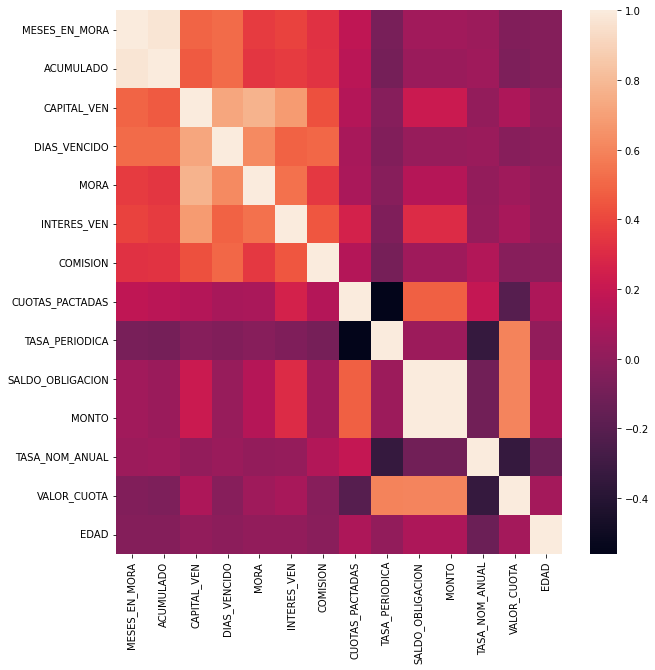

In [170]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:,0].to_list()

# calculate pair-wise correlations between them
corrmat = X_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)


# Bining

In [171]:
feature_list = []

for i in var_num:
    feature_list.append(i)

for i in var_cat:
    feature_list.append(i)

In [172]:
target = 'DEUDOR'

binning_process = BinningProcess(variable_names=feature_list)
binning_process.fit(loan_data[feature_list], loan_data[target])
binning_result = binning_process.summary()



In [173]:
binning_result.sort_values('iv',ascending=False)


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
20,COD_MODALIDAD,categorical,OPTIMAL,True,7,0.323919,0.035781,0.215462,0.312251
7,CUOTAS_PACTADAS,numerical,OPTIMAL,True,6,0.137363,0.016489,0.170957,0.202809
14,LINEA,categorical,OPTIMAL,True,4,0.137324,0.015079,0.109611,0.22735
15,DESTINACION,categorical,OPTIMAL,True,4,0.127838,0.01417,0.100803,0.340272
8,TASA_PERIODICA,numerical,OPTIMAL,True,3,0.08089,0.009777,0.101818,0.172113
9,SALDO_OBLIGACION,numerical,OPTIMAL,True,5,0.070393,0.008707,0.124354,0.089472
10,MONTO,numerical,OPTIMAL,True,5,0.07019,0.008682,0.123993,0.091318
24,MUNICIPIO_CLIENTE,categorical,OPTIMAL,True,9,0.058064,0.007191,0.123743,0.037983
22,CODEUDOR_REF,categorical,OPTIMAL,True,2,0.056695,0.007066,0.114953,0.143719
19,TIPO_CREDITO,categorical,OPTIMAL,True,4,0.049039,0.006095,0.114122,0.171418
